# **Final Project: Insurance Claims Fraud Detection Lab**

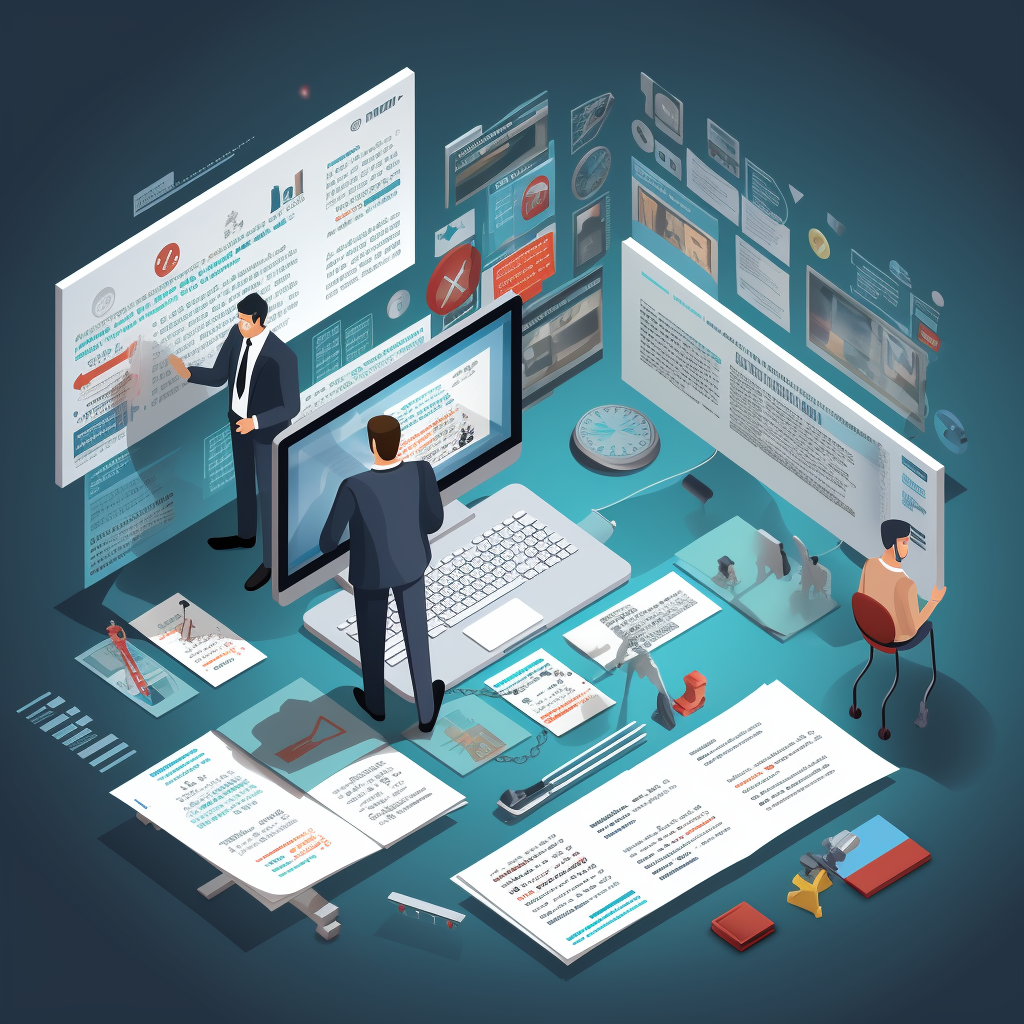

# **Task 1: Import Initial Libraries and Datasets**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
insurance_df = pd.read_csv('insurance_claims.csv')

In [ ]:
!pip install tensorflow-gpu==2.10.0

In [ ]:
!pip install keras-tuner

In [ ]:
!pip install lime
!pip install shap

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import shap
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
import xgboost as xgb

# Load the dataset
insurance_df = pd.read_csv('insurance_claims.csv')

# Drop completely empty columns first
insurance_df.dropna(axis=1, how='all', inplace=True)

# Replace '?' with np.nan
insurance_df.replace('?', np.nan, inplace=True)

# Fill NaN values with the mode of each column
for column in insurance_df.columns:
    mode_val = insurance_df[column].mode()
    if not mode_val.empty:  # Check if mode is not empty
        insurance_df[column].fillna(mode_val.iloc[0], inplace=True)  # Use the first mode value if there are multiple modes

# Convert 'incident_date' and 'policy_bind_date' columns to datetime format
insurance_df['incident_date'] = pd.to_datetime(insurance_df['incident_date'])
insurance_df['policy_bind_date'] = pd.to_datetime(insurance_df['policy_bind_date'])

# Convert target variable to binary format
insurance_df['fraud_reported'] = insurance_df['fraud_reported'].map({'Y': 1, 'N': 0})

# Extract useful features from 'incident_date' and 'policy_bind_date'
insurance_df['incident_month'] = insurance_df['incident_date'].dt.month
insurance_df['incident_day_of_week'] = insurance_df['incident_date'].dt.dayofweek
insurance_df['policy_bind_year'] = insurance_df['policy_bind_date'].dt.year

# Drop original date columns
insurance_df.drop(['incident_date', 'policy_bind_date'], axis=1, inplace=True)

# Converting all int64 columns to float64
int_columns = insurance_df.select_dtypes(include=['int64']).columns
insurance_df[int_columns] = insurance_df[int_columns].astype('float64')

# Identifying the numeric and categorical columns
numeric_features = ['months_as_customer', 'age', 'policy_deductable',
                    'policy_annual_premium', 'umbrella_limit', 'capital-gains',
                    'capital-loss', 'incident_hour_of_the_day',
                    'number_of_vehicles_involved', 'bodily_injuries',
                    'witnesses', 'total_claim_amount', 'injury_claim',
                    'property_claim', 'vehicle_claim', 'incident_month',
                    'incident_day_of_week', 'policy_bind_year']

categorical_features = ['policy_state', 'policy_csl', 'insured_sex',
                        'insured_education_level', 'insured_occupation',
                        'insured_hobbies', 'insured_relationship', 'incident_type',
                        'collision_type', 'incident_severity', 'authorities_contacted',
                        'incident_state', 'policy_state', 'incident_city',
                        'property_damage', 'police_report_available']

# Separate features (X) and target (y) variables
y = insurance_df['fraud_reported']
X = insurance_df.drop(columns=['fraud_reported', 'incident_location', 'insured_zip', 'policy_number', 'auto_model', 'auto_year', 'auto_make'])

# Create a ColumnTransformer with StandardScaler for numeric features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse=False), categorical_features)  # Ensure dense output
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform the test data with the same preprocessor
X_test_scaled = preprocessor.transform(X_test)

# Extract feature names after transformation
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Summarize class distribution before SMOTE
counter_before = Counter(y_train)
print("Before SMOTE:", counter_before)

# Apply SMOTE to the training set
sm = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Summarize the new class distribution after SMOTE
counter_after = Counter(y_train_resampled)
print("After SMOTE:", counter_after)

# Feature selection using XGBoost
selector_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
selector_model.fit(X_train_resampled, y_train_resampled)
sfm = SelectFromModel(selector_model, threshold="mean", prefit=True)
X_train_selected = sfm.transform(X_train_resampled)
X_test_selected = sfm.transform(X_test_scaled)

# Model building with Keras Tuner for hyperparameter optimization
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=32), input_shape=(X_train_selected.shape[1],), kernel_regularizer=l2(hp.Float('l2', 1e-4, 1e-2))))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5)))
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=512, step=32), kernel_regularizer=l2(hp.Float('l2_' + str(i), 1e-4, 1e-2))))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')), loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=2, directory='my_dir', project_name='insurance_fraud')

# Tuning model with early stopping and checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Hyperparameter search
tuner.search(X_train_selected, y_train_resampled, validation_split=0.2, epochs=50, callbacks=[early_stopping, checkpoint, reduce_lr])

# Best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Model evaluation
y_pred = (best_model.predict(X_test_selected) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Model Interpretability with SHAP
explainer = shap.KernelExplainer(best_model.predict, X_train_selected[:100])
shap_values = explainer.shap_values(X_test_selected[:10])
shap.summary_plot(shap_values, X_test_selected[:10], feature_names=feature_names)

# Lime Interpretation (Optional, already included)
# Modify the model prediction function for LIME
def predict_proba_for_lime(X):
    proba = best_model.predict(X)
    return np.hstack([1 - proba, proba])  # Stack the probabilities for class 0 and class 1

# Lime Interpretation (Optional, already included)
explainer_lime = LimeTabularExplainer(X_train_selected, feature_names=feature_names, class_names=['Not Fraud', 'Fraud'], discretize_continuous=True)
i = 0  # Change this to the index of the test sample you want to explain
exp = explainer_lime.explain_instance(X_test_selected[i], predict_proba_for_lime, num_features=10)
exp.show_in_notebook(show_table=True)




In [ ]:
# Modify the model prediction function for LIME
def predict_proba_for_lime(X):
    proba = best_model.predict(X)
    return np.hstack([1 - proba, proba])  # Stack the probabilities for class 0 and class 1

# Lime Interpretation (Optional, already included)
explainer_lime = LimeTabularExplainer(X_train_selected, feature_names=feature_names, class_names=['Not Fraud', 'Fraud'], discretize_continuous=True)
i = 0  # Change this to the index of the test sample you want to explain
exp = explainer_lime.explain_instance(X_test_selected[i], predict_proba_for_lime, num_features=10)
exp.show_in_notebook(show_table=True)


In [ ]:
# Check the shape of the resampled training data
input_shape = X_train_resampled.shape[1]
print(f"Input shape: {input_shape}")

# Define the ANN classifier
ANN_classifier = tf.keras.models.Sequential()

# Add layers to the model
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(input_shape,)))

ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))

ANN_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
ANN_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ANN_classifier.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = ANN_classifier.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")


In [ ]:
# Train the model with the resampled data
epochs_hist = ANN_classifier.fit(X_train_resampled, y_train_resampled, epochs=10)

# Plot the training loss
plt.plot(epochs_hist.history['loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])
plt.show()

# Plot the training accuracy
plt.plot(epochs_hist.history['accuracy'])
plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy'])
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = ANN_classifier.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping  # Add this import

# Define a new ANN classifier with higher dropout and stronger regularization
ANN_classifier_improved = tf.keras.models.Sequential()

# Add layers with increased dropout and L2 regularization
ANN_classifier_improved.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=l2(0.02)))
ANN_classifier_improved.add(tf.keras.layers.Dropout(0.6))

ANN_classifier_improved.add(tf.keras.layers.Dense(units=400, activation='relu', kernel_regularizer=l2(0.02)))
ANN_classifier_improved.add(tf.keras.layers.Dropout(0.6))

ANN_classifier_improved.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the improved model
ANN_classifier_improved.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the improved model with early stopping
epochs_hist_improved = ANN_classifier_improved.fit(X_train_resampled, y_train_resampled, epochs=50, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Evaluate the improved model on the test set
test_loss_improved, test_accuracy_improved = ANN_classifier_improved.evaluate(X_test_scaled, y_test)

print(f"Improved Test Loss: {test_loss_improved}")
print(f"Improved Test Accuracy: {test_accuracy_improved}")


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Load the dataset
#file_path = '/mnt/data/insurance_claims.csv'
#insurance_df = pd.read_csv(file_path)

# Drop completely empty columns
insurance_df.dropna(axis=1, how='all', inplace=True)

# Replace '?' with np.nan
insurance_df.replace('?', np.nan, inplace=True)

# Fill NaN values with the mode of each column
for column in insurance_df.columns:
    mode_val = insurance_df[column].mode()
    if not mode_val.empty:  # Check if mode is not empty
        insurance_df[column].fillna(mode_val.iloc[0], inplace=True)  # Use the first mode value if there are multiple modes

# Convert 'incident_date' and 'policy_bind_date' columns to datetime format
insurance_df['incident_date'] = pd.to_datetime(insurance_df['incident_date'])
insurance_df['policy_bind_date'] = pd.to_datetime(insurance_df['policy_bind_date'])

# Convert target variable to binary format
insurance_df['fraud_reported'] = insurance_df['fraud_reported'].map({'Y': 1, 'N': 0})

# Extract useful features from 'incident_date' and 'policy_bind_date'
insurance_df['incident_month'] = insurance_df['incident_date'].dt.month
insurance_df['incident_day_of_week'] = insurance_df['incident_date'].dt.dayofweek
insurance_df['policy_bind_year'] = insurance_df['policy_bind_date'].dt.year

# Drop original date columns
insurance_df.drop(['incident_date', 'policy_bind_date'], axis=1, inplace=True)

# Drop irrelevant columns
insurance_df.drop(columns=['policy_number', 'incident_location', 'insured_zip', 'auto_model', 'auto_year', 'auto_make'], inplace=True)

# Identify numeric and categorical columns
numeric_features = insurance_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('fraud_reported')
categorical_features = insurance_df.select_dtypes(include=[object]).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse=False), categorical_features)
    ])

# Separate features (X) and target (y)
X = insurance_df.drop(columns=['fraud_reported'])
y = insurance_df['fraud_reported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform the test data with the same preprocessor
X_test_scaled = preprocessor.transform(X_test)

# Step 2: Build and Train the ANN Classifier
ANN_classifier = tf.keras.models.Sequential()




In [ ]:
# Adjust class weights
class_weights = {0: 1, 1: len(y_train) / sum(y_train)}

# Add layers
ANN_classifier = tf.keras.models.Sequential()
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(X_train_scaled.shape[1],)))
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))
ANN_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model with class weights
ANN_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
epochs_hist = ANN_classifier.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), class_weight=class_weights)


# Step 3: Evaluate the Model

# Plot the training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_hist.history['loss'], label='Training Loss')
plt.plot(epochs_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_hist.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate on the test set
y_pred = (ANN_classifier.predict(X_test_scaled) > 0.5).astype("int32")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Rebuild the model and train it on the resampled data
ANN_classifier = tf.keras.models.Sequential()
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(X_train_resampled.shape[1],)))
ANN_classifier.add(tf.keras.layers.Dense(units=400, activation='relu'))
ANN_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
ANN_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on resampled data
epochs_hist = ANN_classifier.fit(X_train_resampled, y_train_resampled, epochs=50, validation_data=(X_test_scaled, y_test))

# Evaluate the model
y_pred = (ANN_classifier.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

def build_model(hp):
    model = tf.keras.Sequential()

    # Add layers with dropout and L2 regularization
    model.add(Dense(units=400, activation='relu', input_shape=(X_train_resampled.shape[1],)))
    model.add(Dropout(0.5))

    model.add(Dense(units=400, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=1, activation='sigmoid'))

    # Tune the learning rate
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='fraud_detection'
)


In [ ]:
tuner.search(X_train_resampled, y_train_resampled, epochs=50, validation_data=(X_test_scaled, y_test))

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(X_train_resampled, y_train_resampled, epochs=50, validation_data=(X_test_scaled, y_test))

# Evaluate the model
y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Define the model
def create_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_selected.shape[1],), kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom Keras wrapper
class KerasClassifierWithParams(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=None):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validation_split = validation_split
        self.callbacks = callbacks if callbacks is not None else []
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                        verbose=self.verbose, validation_split=self.validation_split,
                        callbacks=self.callbacks)
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        proba = self.model_.predict(X)
        return np.hstack((1 - proba, proba))  # Return both class probabilities

# Use cross_val_score with custom Keras model
model = KerasClassifierWithParams(build_fn=create_model, epochs=100, batch_size=32, verbose=1)
scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=5, scoring='recall')

print("Cross-validated scores:", scores)
print("Mean cross-validated score:", np.mean(scores))

# Fit the model on the entire training set with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_selected, y_train_resampled)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test_selected)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot and save the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Predict labels for the test set
y_pred = model.predict(X_test_selected)

# Print classification report
print(classification_report(y_test, y_pred))


# LIME explanation
explainer = LimeTabularExplainer(
    training_data=X_train_selected,
    feature_names=feature_names,  # Use the feature names defined earlier
    class_names=['Non-Fraud', 'Fraud'],  # Adjust based on your problem
    mode='classification'
)

# Explain an instance
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test_selected[i], model.predict_proba, num_features=10)

# Print the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Save the explanation as HTML
exp.save_to_file('lime_explanation.html')

# Optionally, move files to Google Drive (if using Google Colab)
drive.mount('/content/drive')

# Copy files to Google Drive
!cp roc_curve.png /content/drive/MyDrive/
!cp lime_explanation.html /content/drive/MyDrive/

files.download('lime_explanation.html')
files.download('roc_curve.png')

In [ ]:
!pip install keras scikit-learn

# **Task 2: Perform Exploratory Data Analysis**

In [ ]:
# Explore the first five rows in the DataFrame
insurance_df.head(3)

In [ ]:
# Display basic information and the first few rows of the dataset
insurance_df.info()

In [ ]:
# Generate statistical summary
insurance_df.describe()

# **Task 3: Perform Data Preprocessing & Data Visualization**

## **Discussion & Analysis:**

### **Knowing Your Data: (Exploring the Dataset):**

In [ ]:
column_name = []
unique_value = []
most_common = []
least_common = []
column_type = []

# Iterate through the columns
for col in insurance_df:
    # If 2 or fewer unique categories
    column_name.append(str(col))
    unique_value.append(insurance_df[col].nunique())
    column_type.append(str(insurance_df[col].dtype))

    value_counts = insurance_df[col].value_counts()

    # Check if value_counts is not empty
    if not value_counts.empty:
        # Get the most common value and its count
        most_common_value = value_counts.idxmax()
        most_common_count = value_counts.max()
        most_common.append(f"{most_common_value} ({most_common_count})")

        # Get the least common value and its count
        least_common_value = value_counts.idxmin()
        least_common_count = value_counts.min()
        least_common.append(f"{least_common_value} ({least_common_count})")
    else:
        # In case of empty value_counts (all elements are NaN), we append 'NaN' to the corresponding lists
        most_common.append('NaN')
        least_common.append('NaN')

table = pd.DataFrame()
table['Column Name'] = column_name
table['Unique Values'] = unique_value
table['Most Common'] = most_common
table['Least Common'] = least_common
table['Data Type'] = column_type

table = table.sort_values('Unique Values', ascending=False)
table


# **Observations:**

- policy_number and incident_location are unique identifiers for each row in your dataset. Since these are unique for each row, they probably won't be useful for making predictions in a machine learning model.

- insured_zip and policy_annual_premium have very high cardinality. They are numerical fields with many distinct values. This suggests a lot of variability in these features, which could be useful for a machine learning model.

- policy_bind_date also has a high cardinality, but it is a date field. There may be some temporal trends that could be useful to extract from this feature.

- total_claim_amount, vehicle_claim, injury_claim, and property_claim are important features. They have high cardinality indicating a wide range of claim amounts. If there are certain values that are particularly common, these could potentially be associated with fraudulent activities.

- capital-loss and capital-gains have a substantial amount of zero values which indicates that most customers haven't experienced capital loss or gain.

- age, auto_model, incident_hour_of_the_day, auto_year, insured_hobbies and insured_occupation are also high-cardinality categorical variables. This suggests a diverse customer base.

- umbrella_limit is an interesting feature. It seems there's a substantial number of policies with no umbrella limit (as suggested by 798 occurrences of '0'). It would be interesting to see how this feature correlates with fraud_reported.

- There are several categorical variables with a smaller number of unique values, such as insured_education_level, incident_state, incident_city, insured_relationship, authorities_contacted, collision_type, incident_severity, incident_type, property_damage, police_report_available, policy_deductable, policy_csl, policy_state, insured_sex. These variables can be used to segment the data and may provide valuable insight when combined with other variables.

- fraud_reported, the target variable, is binary with more instances of 'No' (753 occurrences) than 'Yes' (247 occurrences). This indicates an imbalanced class problem, which may require special techniques when training a machine learning model.

- A few features such as collision_type, property_damage, and police_report_available appear to have missing values (as indicated by the '?'). These missing values will need to be handled before building a machine learning model.

Remember, this is just a high-level overview. You would need to perform more detailed exploratory data analysis and consider the context of the data to draw more concrete conclusions.

# **Outliers**

In [ ]:
import numpy as np

def detect_outliers(df, features):
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[col], 75) # 3rd quartile (75%)
        IQR = Q3 - Q1 # Interquartile range (IQR)

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

        # print the number of outliers and the outlier data for each feature
        print(f"\nOutliers detected for {col}: {len(outlier_list_col)} instances")
        print(df.loc[outlier_list_col])

    # remove duplicate indices
    outlier_indices = list(set(outlier_indices))

    return outlier_indices

num_features = ['policy_annual_premium', 'total_claim_amount', 'vehicle_claim',
                'injury_claim', 'property_claim', 'capital-loss',
                'capital-gains', 'age', 'umbrella_limit']

outlier_indices = detect_outliers(insurance_df, num_features)
print(f"\nTotal number of unique outliers detected across all features: {len(outlier_indices)}")


- Policy Annual Premium: Outliers were identified in 9 instances, including policy numbers 790442, 649082, 241562, 326322, 349658, 719989, 230223, 984456, and 728025. These policies exhibit unusually high or low premiums, necessitating further analysis.

- Total Claim Amount: Policy number 214618 stands out with an exceptionally high total claim amount, marking it as an outlier.

- Vehicle Claim: All vehicle claim amounts are within a normal range, with no outliers detected.

- Injury Claim: Similarly, injury claim amounts are consistent and within expected limits, with no outliers.

- Property Claim: Six policies (numbers 346940, 515698, 714929, 357949, 528385, and 238196) are outliers in property claims, indicating significantly divergent claim amounts.

- Capital-Loss & Capital-Gains: No outliers were found in the capital-loss and capital-gains data, indicating typical financial transactions for the policies.

- Age: Four policyholders (policy numbers 346002, 852002, 911429, and 531160) are notably older than average, making their ages outliers.

- Umbrella Limit: A considerable number (202 out of 218) of policies have umbrella limits that are outliers, suggesting abnormally high coverage limits.

- Policy Details: The distribution of policies is well-balanced across OH, IL, and IN, with no clear dominance in terms of policy CSL and deductible.

- Insured Details: The dataset shows a balanced gender distribution with a slight female majority. Education levels are evenly spread, predominantly at the JD and High School levels. Reading and basketball are the most and least common hobbies, respectively, and 'own-child' is the most frequent relationship status.

- Incident Details: Multi-vehicle and single-vehicle collisions are prevalent. Rear collisions are the most common, while minor damage incidents outnumber total loss and major damage incidents.

- Authority Contact and Incident Location: Police reports are most common, followed by fire services and ambulance calls. NY, SC, and WV have the highest incident occurrences, with Springfield, Arlington, and Columbus being the top cities.

- Property Damage and Police Reports: Entries suggest that property damage is not always present, and police reports are not consistently available.

These observations provide insights into the dataset's characteristics but do not necessarily imply direct correlations with fraud. Analyzing how outliers in features like umbrella_limit correlate with fraudulent claims could be informative. For instance, understanding whether outliers in umbrella_limit are more common in fraudulent claims could guide outlier management strategies.

# **Missing Data**

In [ ]:
# Count of 'np.nan' for each column
nan_count = insurance_df.isnull().sum()

# Count of '?' for each column
question_mark_count = insurance_df.eq('?').sum()

# Combine the two Series into a DataFrame for a better view
missing_values_df = pd.DataFrame({'nan_count': nan_count, 'question_mark_count': question_mark_count})

print(missing_values_df)

#In this code:

#We calculate the count of np.nan values and ? values separately for each column using isnull().sum() and eq('?').sum() respectively,
#and store these in nan_count and question_mark_count.

#We then create a new DataFrame missing_values_df that has two columns: nan_count and
#question_mark_count. This DataFrame gives you a comprehensive view of the missing values in each column of insurance_df,
#irrespective of whether they are denoted as np.nan or ?.

In [ ]:
# now plot the heatmap with missing values represented as 'np.nan'
sns.heatmap(insurance_df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

# **Analyzing the Imbalance in 'Insurance_claims' Dataset**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the counts
counts = insurance_df['fraud_reported'].value_counts()
print(counts)

f, ax = plt.subplots(figsize=(10, 10))
sns_countplot = sns.countplot(x='fraud_reported', data=insurance_df)

# Setting custom labels for the x-ticks
ax.set_xticklabels(['Non-fraud = 0', 'Fraud = 1'])

# Adding legend using the patches of the countplot and incorporating the counts
labels = [f'Non-fraud ({counts[0]})', f'Fraud ({counts[1]})']
ax.legend(handles=sns_countplot.patches, labels=labels, loc='upper right')

plt.show()


# **Distribution of Incident By State**

In [ ]:
import geopandas as gpd
import pandas as pd
import folium

# Create a DataFrame that counts the incidents by state
incident_counts = insurance_df['State'].value_counts().reset_index()
incident_counts.columns = ['State', 'Counts']

# The coordinates for each state's label
state_coords = {
    'South Carolina': [33.8361, -81.1637],
    'Virginia': [37.4316, -78.6569],
    'Albany': [40.7128, -74.0060],  # This refers to New York state
    'Ohio': [40.4173, -82.9071],
    'West Virginia': [38.5976, -80.4549],
    'North Carolina': [35.7596, -79.0193],
    'Pennsylvania': [41.2033, -77.1945]
}

# Create a basic map centered on the U.S.
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Define a function to set color based on number of incidents
def set_color(count):
    if count <= 50:
        return 'green'
    elif 50 < count <= 150:
        return 'orange'
    else:
        return 'red'

# Adding the states and their incident counts to the map
for idx, row in incident_counts.iterrows():
    state = row['State']
    count = row['Counts']

    # Check if the state exists in our coordinates dictionary
    if state in state_coords:
        folium.CircleMarker(
            location=state_coords[state],
            radius=10,
            color=set_color(count),
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

        # Add the number of incidents as a label in the middle of the circle
        folium.Marker(
            location=state_coords[state],
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color: black;">{count}</div>""")
        ).add_to(m)

# Adding a legend to the map
legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; z-index:9999; font-size:14px;">
    &nbsp;<b>States:</b><br>
'''

for state, color in zip(state_coords.keys(), ["green", "orange", "red"]):
    legend_html += f'<i class="fa fa-circle" style="color:{color}"></i> {state}<br>'

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

m.save('incident_map_with_legend.html')
m


## **Step 1: Data Cleaning and Initial Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

# Drop completely empty columns first
insurance_df.dropna(axis=1, how='all', inplace=True)

# Replace '?' with np.nan
insurance_df.replace('?', np.nan, inplace=True)

# Fill NaN values with the mode of each column
for column in insurance_df.columns:
    mode_val = insurance_df[column].mode()
    if not mode_val.empty:  # Check if mode is not empty
        insurance_df[column].fillna(mode_val.iloc[0], inplace=True)  # Use the first mode value if there are multiple modes

# Convert 'incident_date' and 'policy_bind_date' columns to datetime format
insurance_df['incident_date'] = pd.to_datetime(insurance_df['incident_date'])
insurance_df['policy_bind_date'] = pd.to_datetime(insurance_df['policy_bind_date'])

# Convert target variable to binary format
insurance_df['fraud_reported'] = insurance_df['fraud_reported'].map({'Y': 1, 'N': 0})


## **Step 2: Feature Engineering**

###**Feature Engineering: Extracting Date Components from Incident and Policy Dates**

In [ ]:
# Extract useful features from 'incident_date' and 'policy_bind_date'
insurance_df['incident_month'] = insurance_df['incident_date'].dt.month
insurance_df['incident_day_of_week'] = insurance_df['incident_date'].dt.dayofweek
insurance_df['policy_bind_year'] = insurance_df['policy_bind_date'].dt.year

# Drop original date columns
insurance_df.drop(['incident_date', 'policy_bind_date'], axis=1, inplace=True)


###**Feature Type Conversion and Identification for Insurance Dataset**

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Converting all int64 columns to float64
int_columns = insurance_df.select_dtypes(include=['int64']).columns
insurance_df[int_columns] = insurance_df[int_columns].astype('float64')

# Identifying the numeric and categorical columns
numeric_features = ['months_as_customer', 'age', 'policy_deductable',
                    'policy_annual_premium', 'umbrella_limit', 'capital-gains',
                    'capital-loss', 'incident_hour_of_the_day',
                    'number_of_vehicles_involved', 'bodily_injuries',
                    'witnesses', 'total_claim_amount', 'injury_claim',
                    'property_claim', 'vehicle_claim', 'fraud_reported',
                    'incident_month', 'incident_day_of_week', 'policy_bind_year']

categorical_features = ['policy_state', 'policy_csl', 'insured_sex',
                        'insured_education_level', 'insured_occupation',
                        'insured_hobbies', 'insured_relationship', 'incident_type',
                        'collision_type', 'incident_severity', 'authorities_contacted',
                        'incident_state', 'policy_state', 'incident_city',
                        'property_damage', 'police_report_available']


In [ ]:
insurance_df.info()

## **Step 3: Preparing Target Variable and Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assuming insurance_df is your DataFrame and 'fraud_reported' is the target column
# Make sure to separate features (X) and target (y) variables

# Define the target and feature names
y = insurance_df['fraud_reported']
X = insurance_df.drop(columns=['fraud_reported', 'incident_location', 'insured_zip', 'policy_number', 'auto_model', 'auto_year', 'auto_make'])

# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create a ColumnTransformer with StandardScaler for numeric features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform the test data with the same preprocessor
X_test_scaled = preprocessor.transform(X_test)

# Extract feature names after transformation
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Summarize class distribution before SMOTE
counter_before = Counter(y_train)
print("Before SMOTE:", counter_before)

# Apply SMOTE to the training set
sm = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Summarize the new class distribution after SMOTE
counter_after = Counter(y_train_resampled)
print("After SMOTE:", counter_after)


# **SMOTE During Model Training:**

- No Data Leakage: If you're applying SMOTE only to the training data after splitting the dataset, there's no risk of data leakage. The model will be tested on real, unseen data, providing a more accurate performance estimate.
- More Realistic Scenario: Applying SMOTE only to the training set reflects a more realistic scenario where the model encounters imbalanced data in the real world, as is often the case in fraud detection.

In [ ]:
# Display basic information and the first few rows of the dataset
insurance_df.info()

# **Missing Data After Preprocessing - Data Post Handling of Missing Values**

In [ ]:
# check if there are any Null values
insurance_df.isnull().sum()

In [ ]:
# check if there are any Null values
sns.heatmap(insurance_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

# **Checking the Dataset Colorations:**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#insurance_df.corr()

# Calculate correlation matrix for numerical columns
corr_matrix = insurance_df.corr(numeric_only=True)

# Initialize a DataFrame to store the significant correlations
significant_correlations = pd.DataFrame(columns=["Feature1", "Feature2", "Correlation"])

# Iterate over the matrix's entries
for col in corr_matrix.columns:
    for idx in corr_matrix.index:
        # Skip self-correlations
        if col != idx:
            # Store significant correlations in the DataFrame. Feel free to change the threshold
            if abs(corr_matrix.loc[idx, col]) > 0.5:
                new_row = pd.DataFrame({"Feature1": [idx],
                                        "Feature2": [col],
                                        "Correlation": [corr_matrix.loc[idx, col]]})
                significant_correlations = pd.concat([significant_correlations, new_row], ignore_index=True)

# Print significant correlations
print(significant_correlations)


plt.figure(figsize = (15, 10))
sns.heatmap(insurance_df.corr(), annot = True);
# months as customer and age have positive correlations with charges

Here are some key observations from the results:

1- "months_as_customer" and "age" have a very high positive correlation (0.92), which means that as the number of months as a customer increases, the age of the customer also tends to increase.

2- "total_claim_amount" is highly positively correlated with "injury_claim" (0.805), "property_claim" (0.811), and "vehicle_claim" (0.983). This means that when the total claim amount increases, the amounts of these individual types of claims also tend to increase.

3- "incident_hour_of_the_day" has a positive correlation with "number_of_vehicles_involved" (0.12) and "total_claim_amount" (0.218), meaning these variables tend to increase together.

4- "auto_year" shows very low correlation with other variables, implying that the year of the automobile is generally not a strong indicator for other variables in the dataset.

5- "capital-gains" and "capital-loss" show a negative correlation (-0.047), indicating that as capital gains increase, capital losses tend to decrease, and vice versa.

6- "policy_deductable" and "bodily_injuries" show a negative correlation (-0.023), meaning as policy deductible increases, bodily injuries tend to decrease.

Remember, correlation does not imply causation. These are just statistical relationships and don't indicate that one variable's movement directly causes the other to change.

In [ ]:
insurance_df[['injury_claim', 'total_claim_amount', 'property_claim', 'vehicle_claim', 'auto_year', 'fraud_reported', 'age','months_as_customer']].hist(bins = 30, figsize = (12, 12), color = 'r');

#Descriptive statistics
# List of column names
cols = ['injury_claim', 'total_claim_amount', 'property_claim', 'vehicle_claim', 'auto_year', 'age', 'months_as_customer', 'fraud_reported']

# Generate descriptive statistics
report = insurance_df[cols].describe(include='all')

print(report)

In [ ]:
# plot pairplot
sns.pairplot(insurance_df)

# **Understanding your Data Distribution to Output Features (Fraud_Reported)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Variables of interest and their names
variables = {
    'insured_hobbies': "Insured Hobbies",
    'incident_type': "Incident Type",
    'auto_make': "Auto Make",
    'umbrella_limit': "Umbrella Limit"
}

# Create subplots
fig, ax = plt.subplots(len(variables), 1, figsize=(20, 20))

for i, (var, name) in enumerate(variables.items()):
    # Plot counts
    sns.countplot(data=insurance_df, x=var, hue='fraud_reported', ax=ax[i])
    ax[i].set_title(f'Fraud reported by {name}')

    # Compute the percentage of fraud reported
    fraud_by_var = insurance_df.groupby(var)['fraud_reported'].mean() * 100

    display(Markdown(f"""
    ### {name}
    The percentages of fraud reported per {name.lower()} are as follows:\n
    {fraud_by_var.to_string()}
    """))

# Show the plot
plt.tight_layout()
plt.show()


From the analysis, the following observations can be made:

**1. Insured Hobbies:**

* Chess (82.6%) and cross-fit (74.3%) are the hobbies associated with the highest percentage of reported fraud.
* Meanwhile, hobbies like camping (9.09%) and kayaking (9.26%) are associated with the lowest fraud reports.
* This suggests that there might be a correlation between specific hobbies and the likelihood of a claim being fraudulent.



**2. Incident Type:**

* Single Vehicle Collision (29.03%) and Multi-vehicle Collision (27.21%) have the highest percentage of reported fraud among incident types.
* Vehicle Theft (8.51%) and Parked Car (9.52%) incidents have the lowest rates of fraud.
* This suggests that incidents involving collisions are more likely to be associated with fraudulent claims.

**3. Auto Make:**

* Mercedes (33.85%) and Audi (30.43%) have the highest percentage of reported fraud among car makes.
* Jeep (16.42%) and Nissan (17.95%) are at the lower end of the spectrum.
* This indicates that certain car brands might be more commonly associated with fraudulent claims, possibly due to factors such as their value or theft rate.

**4. Umbrella Limit:**

* Policies with an umbrella limit of 2,000,000 and 10,000,000 show high fraud report percentages (66.67% and 50.00% respectively).
* However, policies with an umbrella limit of -1,000,000 and 3,000,000 have significantly lower rates (0.00% and 16.67% respectively).
* This could mean that a higher umbrella limit might be associated with a greater likelihood of fraudulent claims, possibly due to the higher potential payout.

# **Task 4: Models Training and Evaluation**

# **Model 1: Train An XG-Boost Classifier Model**

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Initialize XGBoost classifier
#model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 40, use_label_encoder = False)

# Train the model with regularization parameters
model_xgb.fit(X_train_resampled, y_train_resampled)


# Train an XGBoost classifier model
#model_xgb = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 20, use_label_encoder = False)
#model_xgb.fit(X_train, y_train)

# Continue with your prediction and evaluation

the code snippet is used to test the performance of a machine learning model on an unseen dataset, typically referred to as the "test dataset." In the context of model evaluation. Which is crucial for understanding how well the model might perform in real-world scenarios or when presented with new, unseen data.

In [ ]:
# Predictions on the test set
from sklearn.metrics import accuracy_score
y_pred = model_xgb.predict(X_test_scaled)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_xgb = roc_auc_score(y_test, y_pred)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_xgb}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - XGBOOST Model')
plt.show()

# Classification report for XGBOOST
report_XGB = classification_report(y_test, y_pred)
print("\nClassification Report for XGBOOST Model:\n", report_XGB)

Based on the analysis of the dataset, the following observations and results were obtained:

**Dataset Overview:**

Total Number of Fraud Cases: The dataset contains 247 instances of fraud.
Train-Test Split: Initially, the dataset was divided into training and testing sets with an 80-20 split. For the training set, this equates to 192 fraud cases before applying SMOTE. It's crucial to note that the testing set, comprising 20% of the data, was not affected by SMOTE and retained its original distribution.

**Model Performance on Unseen Data:**

Out of 55 fraud cases in the test set, the XGBOOST model correctly identified 37, resulting in a detection accuracy of approximately 67%. This means 18 fraud cases were not detected by the model.

**Confusion Matrix Analysis:**

- True Negatives: 126 cases were correctly classified as non-fraud.

- False Positives: 19 non-fraud cases were incorrectly classified as fraud.

- False Negatives: 18 fraud cases were missed and incorrectly classified as non-fraud.

- True Positives: 37 fraud cases were correctly identified.

ROC AUC Score: The model achieved a score of 0.770846394984326, indicating its capability in distinguishing between the fraud and non-fraud classes.
Classification Report for Logistic Regression:

- For non-fraudulent cases (0.0), the precision is 0.88, recall is 0.87, and the F1-score is 0.87.

- For fraudulent cases (1.0), the precision is 0.66, recall is 0.67, and the F1-score is 0.67.

Overall Accuracy: The model has an accuracy of 81% on the test set.
The weighted averages for precision, recall, and F1-score are 0.82, 0.81, and 0.82, respectively.

**Imbalance in the Target Variable:**

- The target variable, 'fraud_reported', is binary and imbalanced, with 'No' occurring 753 times and 'Yes' 247 times. This imbalance presents a challenge and necessitates special consideration in model training.

**Impact of SMOTE:**

- Before SMOTE Application: The count of non-fraudulent (0.0) to fraudulent (1.0) cases was 608 to 192.

- After SMOTE Application: Both classes were balanced with 608 instances each, demonstrating the effectiveness of SMOTE in addressing class imbalance.
The above findings underscore the model's capability to detect fraud while also highlighting areas for improvement, particularly in reducing false negatives and addressing class imbalance.

# **Identify feature importance**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance
feature_importances = model_xgb.feature_importances_
feature_names = X_train_resampled.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)



In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report

# Assuming 'feature_importances_df' is already created from previous model training
# Select top N important features
N = 15
top_features = feature_importances_df['Feature'].head(N)

# Plot the feature importance for top 15
plt.figure(figsize=(10, 6))
plt.barh(top_features, feature_importances_df.set_index('Feature').loc[top_features, 'Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances in XGBoost Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Reduce training and test set to top N features
X_train_top_features = X_train_resampled[top_features]
X_test_top_features = X_test[top_features]

# Retrain the model
model_xgb_top_features = xgb.XGBClassifier(random_state=42)
model_xgb_top_features.fit(X_train_top_features, y_train_resampled)

# Predictions and evaluation
y_pred_top_features = model_xgb_top_features.predict(X_test_top_features)
print(classification_report(y_test, y_pred_top_features))


# **As it can be seen using Feature Importance enhanced the model**

# **Black Box Challenge in Machine Learning**

In [ ]:
!pip install lime
!pip install shap

## **LIME**

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Your XGBoost model training code remains unchanged...

# Initialize the LIME explainer
# Note: Use training data before SMOTE for more representative explanations
explainer = LimeTabularExplainer(X_train.values,
                                 mode='classification',
                                 training_labels=y_train,
                                 feature_names=X_train.columns.tolist(),
                                 categorical_features=X_train.select_dtypes(include=['category', 'object']).columns.tolist(),
                                 verbose=True,
                                 class_names=['Non-Fraud', 'Fraud'],
                                 kernel_width=3)

# Choose a random instance from the test set
i = np.random.randint(0, X_test.shape[0])
print("Selected instance index:", i)

# Explain the prediction for this instance
exp = explainer.explain_instance(X_test.iloc[i].values, model_xgb.predict_proba, num_features=10)

# Visualize the explanation
# For Jupyter Notebook:
exp.show_in_notebook(show_table=True, show_all=False)
# For other environments, use exp.as_pyplot_figure()

# Display the explanation as a list
print("\nExplanation for instance", i, ":\n", exp.as_list())


# **SHAP**

In [ ]:
import xgboost as xgb
import shap
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# ... [Your XGBoost model training code remains unchanged] ...

# Initialize SHAP Explainer with your XGBoost model
explainer = shap.Explainer(model_xgb)

# Calculate SHAP values for the training set - using the resampled data
shap_values = explainer(X_train_resampled)

# Visualize the explanation for the first instance in your training set
shap.plots.waterfall(shap_values[0])

# Function to print SHAP values as a report for the given instances
def print_shap_report(shap_values, instances, feature_names):
    for idx in range(len(instances)):
        print(f"SHAP values for instance {idx + 1}:")
        shap_instance = pd.Series(shap_values.values[idx], index=feature_names)
        sorted_shap = shap_instance.abs().sort_values(ascending=False)

        # Print only the top 10 most impactful features
        top_features = sorted_shap.head(10).index
        print(shap_instance[top_features])
        print("-----------------------------")

# Print the SHAP report for the first 10 instances in the training set
print_shap_report(shap_values, X_train_resampled.iloc[:10, :], X_train_resampled.columns)


From the outputs, here are some observations related to fraud_reported:

**Vehicle Claim**: This variable often appears to play a significant role in the prediction, whether it's below or above certain thresholds. The direction of its influence varies based on the specific value range.

**Policy State**: This variable seems to consistently impact the likelihood of a fraudulent claim, with specific state like 'IN' often highlighted.

**Policy CSL**: Policy Combined Single Limit (CSL) seems to have a consistent influence on the prediction. When CSL is at a higher level (e.g., 250/500), it may slightly increase the chance of fraudulent activity.

**Insured Hobbies**: Activities such as 'chess' and 'cross-fit' appear in several places. Interestingly, having 'chess' as a hobby seems to decrease the chance of fraud, while 'cross-fit' increases the likelihood. However, these might not be practically significant or actionable insights as hobbies may not directly relate to fraudulent behavior.

**Day of the Week**: The day of the week when the incident occurred appears to be significant in some predictions. It may indicate that certain days of the week are more prone to fraudulent claims.

**Incident Severity**: From the SHAP summary plot, it's apparent that incident severity, especially 'Total Loss' and 'Minor Damage', have a strong impact on the model's prediction. 'Total Loss' significantly increases the likelihood of fraud, while 'Minor Damage' decreases it.

**Vehicle Age and Make**: These features seem to have a strong influence on predictions, where certain ages or makes are more associated with fraudulent claims.

It's important to note that these insights are based on the model's interpretation and actual insights may vary based on the dataset. Furthermore, while these insights could be used to detect potential fraud, they should be used cautiously to avoid unfair bias or discrimination. For instance, factors like hobbies or the day of the week are unlikely to be causal factors in fraud and could reflect other underlying patterns in the data.

# **Model 2: TRAIN AND EVALUATE A LOGISTIC REGRESSION CLASSIFIER**

In [ ]:
X_train

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train a Logistic Regression classifier model
model_LR = LogisticRegression(max_iter=10000)
model_LR.fit(X_train_resampled, y_train_resampled)  # Use the resampled training data


In [ ]:
# Predictions on the test set
y_pred_lr = model_LR.predict(X_test_scaled)

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_LR = roc_auc_score(y_test, y_pred_lr)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_lr)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_LR}")


#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - LOGISTIC REGRESSION CLASSIFIER')
plt.show()

# Classification report for Logistic Regression
report_lr = classification_report(y_test, y_pred_lr)
print("\nClassification Report for Logistic Regression:\n", report_lr)

# **Model 3: TRAIN AND EVALUATE A SUPPORT VECTOR MACHINE CLASSIFIER**

In [ ]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# Train a SVM classifier model
#svm = SVC(max_iter=10000, probability=True, random_state=42) # very bad results so leave it.
#model_svm = CalibratedClassifierCV(svm)  # Wrap SVC in CalibratedClassifierCV
#model_svm.fit(X_train_resampled, y_train_resampled)

svm = LinearSVC(max_iter=10000)
model_svm = CalibratedClassifierCV(svm) # Wrap SVC in CalibratedClassifierCV
model_svm.fit(X_train_resampled, y_train_resampled)

# Compute class weights
#counter = Counter(y_train)
#estimate = counter[0] / counter[1]
#class_weights = {0: 1., 1: estimate}

In [ ]:
# Predictions on the test set
y_pred_svm = model_svm.predict(X_test_scaled)

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_SV = roc_auc_score(y_test, y_pred_svm)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_SV}")


#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - SUPPORT VECTOR MACHINE CLASSIFIER')
plt.show()

# Classification report for Logistic Regression
report_sv = classification_report(y_test, y_pred_svm)
print("\nClassification Report for Support Vector Machine CLASSIFIER:\n", report_sv)

In summary, the significant improvement in the model's performance after switching to LinearSVC suggests that for "Insurance_Claims" specific dataset and problem, a linear decision boundary is more appropriate, or the LinearSVC is better handling the scale and complexity of your data.

In [ ]:
!pip install scikit-optimize

# **SVM Model Optimization**

# **Model 4: TRAIN AND EVALUATE A RANDOM FOREST CLASSIFIER**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier model
model_rf = RandomForestClassifier() #(class_weight=class_weights) if Not used SMOTE need to use class weights
model_rf.fit(X_train_resampled, y_train_resampled)  # This line trains the model using the resampled training data
#The SMOTE algorithm has already handled the class imbalance issue.
#The class weights are used to give more importance to the minority class during training.Since used SMOTE no need for class weights

# Compute class weights
#estimate = counter[0] / counter[1]
#class_weights = {0: 1., 1: estimate}

# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

In [ ]:
# Predictions on the test set
y_predict_rf = model_rf.predict(X_test_scaled)

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_rf = roc_auc_score(y_test, y_predict_rf)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_predict_rf)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_rf}")


#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - RANDOM FOREST CLASSIFIER')
plt.show()

# Classification report for Logistic Regression
report_rf = classification_report(y_test, y_predict_rf)
print("\nClassification Report for RANDOM FOREST CLASSIFIER:\n", report_rf)

# **Model 5: TRAIN AND EVALUATE A K-NEAREST NEIGHBOUR (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a K-Nearest Neighbour (KNN) model
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_resampled, y_train_resampled)  # This line trains the model using the resampled training data

#when using KNeighborsClassifier, make sure your features are scaled, as KNN is a distance-based algorithm and can be sensitive to
#the scale of the data. If your features are not on the same scale, consider using StandardScaler or MinMaxScaler to normalize your features.

In [ ]:
# Predict on the test data
y_pred_knn = model_knn.predict(X_test_scaled) # Changed variable name from y_predict to y_pred for consistency

# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_knn}")

#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - K-NEAREST NEIGHBOUR (KNN)')
plt.show()

# Classification report for Logistic Regression
report_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report for K-NEAREST NEIGHBOUR:\n", report_knn)


# **Model 6: TRAIN AND EVALUATE A NAIVE BAYES CLASSIFIER**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Assuming X_train_resampled is in sparse format
X_train_resampled_dense = X_train_resampled.toarray()

# Train a Gaussian Naive Bayes model
model_gnb = GaussianNB()
model_gnb.fit(X_train_resampled_dense, y_train_resampled)


In [ ]:
# Assuming X_test_scaled is in sparse format
X_test_scaled_dense = X_test_scaled.toarray()

# Predict on the test data
y_predict_nb = model_gnb.predict(X_test_scaled_dense)

# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_nb = roc_auc_score(y_test, y_predict_nb)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_predict_nb)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_nb}")

#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - NAIVE BAYES CLASSIFIER')
plt.show()

# Classification report for Logistic Regression
report_nb = classification_report(y_test, y_predict_nb)
print("\nClassification Report for NAIVE BAYES:\n", report_nb)


# **Model 7: TRAIN AND EVALUATE LGBM Classifier**

In [ ]:
from lightgbm import LGBMClassifier

# Instantiate and train a LGBMClassifier model
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train_resampled, y_train_resampled)  # This line trains the model using the resampled training data

#The LGBMClassifier (Light Gradient Boosting Machine) is a gradient boosting framework that uses tree-based learning algorithms.
#It is designed to be distributed and efficient with the following advantages:
# 1- faster training speed and higher efficiency,
# 2- lower memory usage, better accuracy,
# 3- support of parallel and GPU learning,
# 4- and capable of handling large-scale data.


In [ ]:
# Predict on the test data
y_predict_gbm = model_lgbm.predict(X_test_scaled)

# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_gbm = roc_auc_score(y_test, y_predict_gbm)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_predict_gbm)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_gbm}")

#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - LGBM Classifier')
plt.show()

# Classification report for Logistic Regression
report_gbm = classification_report(y_test, y_predict_gbm)
print("\nClassification Report for LGBM Classifier:\n", report_gbm)


# **Model 8: TRAIN AND EVALUATE Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define your classifiers
classifiers = [('XG-Boost Classifier', model_xgb),
               ('Logistic Regression', model_LR),
               ('Support Vector Machine', model_svm),
               ('Random Forest', model_rf),
               ('K-Nearest Neighbors', model_knn),
               ('Naive Bayes', model_gnb),
               ('LGBM Classifier', model_lgbm)]

# Assuming X_train_resampled is in sparse format
X_train_resampled_dense = X_train_resampled.toarray()

# Instantiate the VotingClassifier
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the VotingClassifier
voting_clf.fit(X_train_resampled_dense, y_train_resampled)  # This line trains the model using the resampled training data


In [ ]:
# Assuming X_test_scaled is in sparse format
X_test_scaled_dense = X_test_scaled.toarray()

# Predict on the test data
y_predict_vc = voting_clf.predict(X_test_scaled_dense)

# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

#from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute the ROC AUC score using predicted probabilities
roc_auc_vc = roc_auc_score(y_test, y_predict_vc)

# Calculate the confusion matrix using the test labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_predict_vc)

# Extracting individual elements from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Formatting and printing the confusion matrix
print("Confusion Matrix:\n")
print(f"True Negatives (Correctly identified as non-fraud): {tn}")
print(f"False Positives (Incorrectly identified as fraud): {fp}")
print(f"False Negatives (Incorrectly identified as non-fraud): {fn}")
print(f"True Positives (Correctly identified as fraud): {tp}")

# Optionally, print the ROC AUC score
print(f"\nROC AUC Score: {roc_auc_vc}")

#from sklearn.metrics import ConfusionMatrixDisplay

# Visualizing the confusion matrix for the XGBOOST model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Fraud', 'Fraud']).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

# Classification report for Logistic Regression
report_vc = classification_report(y_test, y_predict_vc)
print("\nClassification Report for Voting Classifier:\n", report_vc)


# **TASK 5: PLOT ROC CURVES FOR THE 8 MODELS AND FIND AUC SCORES**

In [ ]:
# ROC curve
from sklearn.metrics import roc_curve

fpr0, tpr0, thresh0 = roc_curve(y_test, model_xgb.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr1, tpr1, thresh1 = roc_curve(y_test, model_LR.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, model_svm.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, model_rf.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr4, tpr4, thresh4 = roc_curve(y_test, model_knn.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr5, tpr5, thresh5 = roc_curve(y_test, model_gnb.predict_proba(X_test_scaled_dense)[:, 1], pos_label = 1)
fpr6, tpr6, thresh6 = roc_curve(y_test, model_lgbm.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr7, tpr7, thresh7 = roc_curve(y_test, voting_clf.predict_proba(X_test_scaled_dense)[:, 1], pos_label = 1)


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from scipy.sparse import issparse

# Initialize an empty list for summary
summary = []

# Dictionary of all models
models = {
    "XG-Boost Classifier": model_xgb,
    "Logistic Regression": model_LR,
    "Support Vector Machine": model_svm,
    "Random Forest": model_rf,
    "K-Nearest Neighbors": model_knn,
    "Naive Bayes": model_gnb,
    "LGBM Classifier": model_lgbm,
    "Voting Classifier": voting_clf
}

# Iterate through each model to calculate metrics
for name, model in models.items():
    # Check if the model is Naive Bayes or Voting Classifier which require dense data
    if name in ["Naive Bayes", "Voting Classifier"]:
        # Convert to dense array only if it is a sparse matrix
        X_test_for_model = X_test_scaled_dense.toarray() if issparse(X_test_scaled_dense) else X_test_scaled_dense
    else:
        X_test_for_model = X_test_scaled

    y_predict = model.predict(X_test_for_model)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test_for_model)[:, 1])

    # Classification report
    report_dict = classification_report(y_test, y_predict, output_dict=True)
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1_score = report_dict['weighted avg']['f1-score']

    # Append model metrics to the summary list
    summary.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'AUC': auc_score
    })

# Convert the summary list to a DataFrame for display
summary_df = pd.DataFrame(summary)

# Print the summary DataFrame
print(summary_df)


In [ ]:
from sklearn.metrics import auc

# Compute AUC scores
auc_score0 = auc(fpr0, tpr0)
auc_score1 = auc(fpr1, tpr1)
auc_score2 = auc(fpr2, tpr2)
auc_score3 = auc(fpr3, tpr3)
auc_score4 = auc(fpr4, tpr4)
auc_score5 = auc(fpr5, tpr5)
auc_score6 = auc(fpr6, tpr6)
auc_score7 = auc(fpr7, tpr7)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))

# Define a consistent color for all AUC fill areas, e.g., light blue
auc_fill_color = 'lightblue'
auc_fill_alpha = 0.1  # Transparency of the fill

# Plot each model's ROC curve and fill under curve
plt.plot(fpr0, tpr0, linestyle="--", color="blue", label=f"XG-Boost (AUC = {auc_score0:.2f})")
plt.fill_between(fpr0, tpr0, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr1, tpr1, linestyle="--", color="orange", label=f"Logistic Regression (AUC = {auc_score1:.2f})")
plt.fill_between(fpr1, tpr1, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr2, tpr2, linestyle="--", color="red", label=f"SVM (AUC = {auc_score2:.2f})")
plt.fill_between(fpr2, tpr2, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr3, tpr3, linestyle="--", color="green", label=f"Random Forest (AUC = {auc_score3:.2f})")
plt.fill_between(fpr3, tpr3, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr4, tpr4, linestyle="--", color="grey", label=f"KNN (AUC = {auc_score4:.2f})")
plt.fill_between(fpr4, tpr4, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr5, tpr5, linestyle="--", color="black", label=f"Naive bayes (AUC = {auc_score5:.2f})")
plt.fill_between(fpr5, tpr5, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr6, tpr6, linestyle="--", color="purple", label=f"LGBM Classifier (AUC = {auc_score6:.2f})")
plt.fill_between(fpr6, tpr6, color=auc_fill_color, alpha=auc_fill_alpha)

plt.plot(fpr7, tpr7, linestyle="--", color="pink", label=f"Voting Classifier (AUC = {auc_score7:.2f})")
plt.fill_between(fpr7, tpr7, color=auc_fill_color, alpha=auc_fill_alpha)

# Plotting random performance (AUC = 0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random (AUC = 0.5)')

plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('Fraud Detection Rate (FDR)/ Recall')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('ROC_Shaded.png', dpi=300)
plt.show()

# **TASK 6: Models Comparison**

In [ ]:
import pandas as pd
import plotly.express as px

# Define a list with the model names
models_list = ["XG-Boost Classifier", "Logistic Regression", "Support Vector Machine",
               "Random Forest", "K-Nearest Neighbors", "Naive Bayes", "LGBM Classifier", "Voting Classifier"]

# Define a list with the AUC scores
scores_list = [auc_score0, auc_score1, auc_score2, auc_score3, auc_score4, auc_score5, auc_score6, auc_score7]

# Create a DataFrame from the lists
models_df = pd.DataFrame(list(zip(models_list, scores_list)), columns =['Model', 'Score'])

# Sort DataFrame by score in ascending order
models_df = models_df.sort_values('Score', ascending=True)

# Create the bar plot
fig = px.bar(models_df, y='Model', x='Score', color='Score',
             color_continuous_scale='viridis',
             labels={'Score':'AUC Score'},
             title='Models Comparison',
             template='plotly_dark',
             orientation='h')

# Display the plot
fig.show()


# **Install Important Libraries**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install lime

# **Data Cleaning and Preprocessing for Keras Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from google.colab import drive, files

# Load the dataset
insurance_df = pd.read_csv('insurance_claims.csv')

# Drop completely empty columns first
insurance_df.dropna(axis=1, how='all', inplace=True)

# Replace '?' with np.nan
insurance_df.replace('?', np.nan, inplace=True)

# Fill NaN values with the mode of each column
for column in insurance_df.columns:
    mode_val = insurance_df[column].mode()
    if not mode_val.empty:  # Check if mode is not empty
        insurance_df[column].fillna(mode_val.iloc[0], inplace=True)  # Use the first mode value if there are multiple modes

# Convert 'incident_date' and 'policy_bind_date' columns to datetime format
insurance_df['incident_date'] = pd.to_datetime(insurance_df['incident_date'])
insurance_df['policy_bind_date'] = pd.to_datetime(insurance_df['policy_bind_date'])

# Convert target variable to binary format
insurance_df['fraud_reported'] = insurance_df['fraud_reported'].map({'Y': 1, 'N': 0})

# Extract useful features from 'incident_date' and 'policy_bind_date'
insurance_df['incident_month'] = insurance_df['incident_date'].dt.month
insurance_df['incident_day_of_week'] = insurance_df['incident_date'].dt.dayofweek
insurance_df['policy_bind_year'] = insurance_df['policy_bind_date'].dt.year

# Drop original date columns
insurance_df.drop(['incident_date', 'policy_bind_date'], axis=1, inplace=True)

# Converting all int64 columns to float64
int_columns = insurance_df.select_dtypes(include=['int64']).columns
insurance_df[int_columns] = insurance_df[int_columns].astype('float64')

# Identifying the numeric and categorical columns
numeric_features = ['months_as_customer', 'age', 'policy_deductable',
                    'policy_annual_premium', 'umbrella_limit', 'capital-gains',
                    'capital-loss', 'incident_hour_of_the_day',
                    'number_of_vehicles_involved', 'bodily_injuries',
                    'witnesses', 'total_claim_amount', 'injury_claim',
                    'property_claim', 'vehicle_claim', 'incident_month',
                    'incident_day_of_week', 'policy_bind_year']

categorical_features = ['policy_state', 'policy_csl', 'insured_sex',
                        'insured_education_level', 'insured_occupation',
                        'insured_hobbies', 'insured_relationship', 'incident_type',
                        'collision_type', 'incident_severity', 'authorities_contacted',
                        'incident_state', 'policy_state', 'incident_city',
                        'property_damage', 'police_report_available']

# Separate features (X) and target (y) variables
y = insurance_df['fraud_reported']
X = insurance_df.drop(columns=['fraud_reported', 'incident_location', 'insured_zip', 'policy_number', 'auto_model', 'auto_year', 'auto_make'])

# Create a ColumnTransformer with StandardScaler for numeric features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse=False), categorical_features)  # Ensure dense output
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform the test data with the same preprocessor
X_test_scaled = preprocessor.transform(X_test)

# Extract feature names after transformation
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Summarize class distribution before SMOTE
counter_before = Counter(y_train)
print("Before SMOTE:", counter_before)

# Apply SMOTE to the training set
sm = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Summarize the new class distribution after SMote
counter_after = Counter(y_train_resampled)
print("After SMOTE:", counter_after)


# **Deep Learning - Define the Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Define the model
def create_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_selected.shape[1],), kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom Keras wrapper
class KerasClassifierWithParams(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=None):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validation_split = validation_split
        self.callbacks = callbacks if callbacks is not None else []
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                        verbose=self.verbose, validation_split=self.validation_split,
                        callbacks=self.callbacks)
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        proba = self.model_.predict(X)
        return np.hstack((1 - proba, proba))  # Return both class probabilities

# Use cross_val_score with custom Keras model
model = KerasClassifierWithParams(build_fn=create_model, epochs=100, batch_size=32, verbose=1)
scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=5, scoring='recall')

print("Cross-validated scores:", scores)
print("Mean cross-validated score:", np.mean(scores))

# Fit the model on the entire training set with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_selected, y_train_resampled)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test_selected)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot and save the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Predict labels for the test set
y_pred = model.predict(X_test_selected)

# Print classification report
print(classification_report(y_test, y_pred))

# LIME explanation
explainer = LimeTabularExplainer(
    training_data=X_train_selected,
    feature_names=feature_names,  # Use the feature names defined earlier
    class_names=['Non-Fraud', 'Fraud'],  # Adjust based on your problem
    mode='classification'
)

# Explain an instance
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test_selected[i], model.predict_proba, num_features=10)

# Print the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Save the explanation as HTML
exp.save_to_file('lime_explanation.html')

# Optionally, move files to Google Drive (if using Google Colab)
drive.mount('/content/drive')

# Copy files to Google Drive
!cp roc_curve.png /content/drive/MyDrive/
!cp lime_explanation.html /content/drive/MyDrive/

files.download('lime_explanation.html')
files.download('roc_curve.png')

# **Final Lab Project: Fraud Detection in Insurance Claims Using AutoGluon**

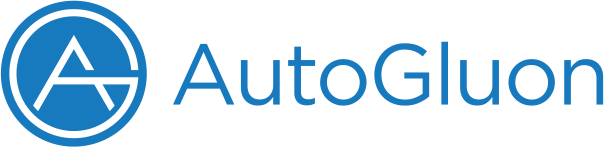

## **Step 1: LOADING IMPORTANT LIBRARIES AND DATASETS**

Let's start by loading the insurance_claims.csv file and conducting an initial exploratory data analysis to understand the dataset's structure. Then, you will follow through with preprocessing and setting up the AutoGluon classifier to predict the 'fraud_reported' column.

In [ ]:
# For Autogluon to work in Google Colab, you need to install ipykernel and restart the notebook
# The IPython kernel is the Python execution backend for Jupyter
!pip install -U ipykernel

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
!pip install autogluon --no-cache-dir

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
file_path = 'insurance_claims.csv'
insurance_claims_df = pd.read_csv(file_path)

insurance_claims_df


# **Step 2: PERFORM EXPLORATORY DATA ANALYSIS**

In [ ]:
# Display the first few rows of the dataframe
insurance_claims_df.head(3)

In [ ]:
# Explore the last five rows in the DataFrame
insurance_claims_df.tail()

In [ ]:
# Generate statistical summary
insurance_claims_df.describe()

In [ ]:
# Display basic information about the dataset
insurance_claims_df_info = insurance_claims_df.info()

insurance_claims_df_info, insurance_claims_df_head

The dataset consists of 1000 entries and 41 columns. Each column represents a feature that could be relevant to insurance claims and potentially to fraud detection. However, it's noted that there is an extra column _c39 which seems to contain only NaN values. This column is likely an artifact of the data collection process and should be removed.




In [ ]:
# check if there are any Null values
sns.heatmap(insurance_claims_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [ ]:
# check if there are any Null values
insurance_claims_df.isnull().sum()

In [ ]:
# plot pairplot
sns.pairplot(insurance_claims_df)

# **Step 3: DATA CLEANING AND PREPROCESSING**

Let's start by cleaning the data and preparing it for analysis and modeling.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Sample data for demonstration purposes
# insurance_claims_df = pd.read_csv('path_to_your_data.csv')

# Data Cleaning Steps
# Remove the column with NaN values
insurance_claims_df.drop(columns=['_c39'], inplace=True)

# Replace '?' with NaN
insurance_claims_df.replace('?', pd.NA, inplace=True)

# Convert dates to datetime objects and extract year, month, and day as separate features
insurance_claims_df['policy_bind_date'] = pd.to_datetime(insurance_claims_df['policy_bind_date'])
insurance_claims_df['incident_date'] = pd.to_datetime(insurance_claims_df['incident_date'])

# Extracting year, month, and day from policy_bind_date
insurance_claims_df['policy_bind_year'] = insurance_claims_df['policy_bind_date'].dt.year
insurance_claims_df['policy_bind_month'] = insurance_claims_df['policy_bind_date'].dt.month
insurance_claims_df['policy_bind_day'] = insurance_claims_df['policy_bind_date'].dt.day

# Extracting year, month, and day from incident_date
insurance_claims_df['incident_year'] = insurance_claims_df['incident_date'].dt.year
insurance_claims_df['incident_month'] = insurance_claims_df['incident_date'].dt.month
insurance_claims_df['incident_day'] = insurance_claims_df['incident_date'].dt.day

# Removing the original date columns as we have extracted the information needed
insurance_claims_df.drop(columns=['policy_bind_date', 'incident_date'], inplace=True)

# Handling missing values by treating them as a separate category
insurance_claims_df.fillna('Unknown', inplace=True)

The target variable **fraud_reported** is indeed imbalanced, with 75.3% of the cases being non-fraudulent ('N') and 24.7% being fraudulent ('Y'). This imbalance will be important to consider when training and evaluating the model.

In terms of missing values, the columns **collision_type, property_damage**, and **police_report_available** have a significant number of missing entries. These missing values need to be handled before training the model. Given the number of missing values and the nature of these variables, it might be reasonable to treat them as a separate category, rather than removing the rows or trying to impute them.


# **Step 4: PREPARING DATA FOR MODELING**

Now, let's proceed to train a classifier model with AutoGluon to predict the fraud_reported column. We'll configure AutoGluon to handle the class imbalance using appropriate methods and evaluate its performance on the test set.

Next steps will include:
1.	Handling missing values by converting them to a separate category.
2.	Encoding categorical features into a format suitable for AutoGluon.
3.	Splitting the data into a training set and a test set.
4.	Training a classifier model with AutoGluon.


In [ ]:
# Encoding categorical variables using a method that is suitable for AutoGluon
# AutoGluon can handle categorical features directly, but let's make sure there are no unsupported data types left
unsupported_object_type_columns = insurance_claims_df.select_dtypes(include=['object']).columns
insurance_claims_df[unsupported_object_type_columns] = insurance_claims_df[unsupported_object_type_columns].astype('category')

# Split the dataset into a training set and a test set
train_df, test_df = train_test_split(insurance_claims_df, test_size=0.2, random_state=42, stratify=insurance_claims_df['fraud_reported'])

# Visualize the distribution of the target variable 'fraud_reported'
fraud_distribution = insurance_claims_df['fraud_reported'].value_counts(normalize=True)

# Checking for missing values after replacements
missing_values = insurance_claims_df.isna().sum()

# Check if the split is successful
train_shape, test_shape = train_df.shape, test_df.shape

fraud_distribution, missing_values, train_shape, test_shape

The data has been successfully split into a training set of 800 entries and a test set of 200 entries, with categorical variables converted to a category data type which AutoGluon can handle efficiently.

# **Step 5: MODEL TRAINING AND EVALUATION WITH AUTOGLUON**

In [ ]:
# Specify the directory where models and intermediate outputs should be saved
save_path = '/mnt/data/autogluon_insurance_model'

# Train multiple ML regression models using AutoGluon
# You need to specify the target column, train_data, limit_time, and presets
# Note that AutoGluon automatically detects if the problem is classification or regression type problems from the 'label' column
# For regression type problems, 'label' values are generally floating point non-integers with large number of unique values

# Initialize the TabularPredictor
predictor = TabularPredictor(label='fraud_reported', path=save_path, eval_metric='accuracy')

#predictor = TabularPredictor(label="fraud_reported", problem_type = 'classification', eval_metric = 'accuracy').fit(train_data = train_df, time_limit = 200, presets = "best_quality")
#Optional Method to choose between#

# Train the predictor with the training data
predictor.fit(train_data=train_df, time_limit=200, presets='best_quality')

# Evaluate the performance on the test data
performance = predictor.evaluate(test_df)

# Get the leaderboard of models trained by AutoGluon
leaderboard = predictor.leaderboard(test_df, silent=True)

performance, leaderboard

predictor.fit_summary()

**The two methods shown above are for initializing and using the TabularPredictor from AutoGluon, but they differ slightly in their setup and usage.**

# **Comparison and Which is Better:**

**Explicit vs. Implicit Problem Type Specification:**

- In Method 1, the problem type (classification or regression) is inferred by AutoGluon based on the data type of the label column.

- Method 2 explicitly specifies it as 'classification'. Explicit specification can be helpful for clarity or in cases where the automatic inference might not align with your intentions.

**Training Approach:**

- Method 1 separates the initialization of the predictor from the training process, which could be useful if you need to perform some operations between these two steps.

- Method 2 combines initialization and training into one step, which is more concise and straightforward if no intermediate processing is required.

**Configurability:**

Method 2 allows you to immediately specify training parameters like time_limit and presets, which can be convenient for quick setups.


**Which to Choose?**

**The choice between these methods depends on your specific needs:**

- If you prefer a clear separation of predictor initialization and training, or if you need to perform operations between these steps, Method 1 might be better.
- If you want a more concise setup where you can immediately train the predictor with specific parameters, Method 2 is preferable.

Both methods are correct and can be used effectively depending on the context of your project and your coding style preferences. The "best" method is the one that aligns well with your workflow and requirements for the task at hand.

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score, roc_auc_score

# Load the saved predictor
predictor = TabularPredictor.load("/mnt/data/autogluon_insurance_model")

# Get the leaderboard
leaderboard = predictor.leaderboard(test_df, silent=True)

# Get the true labels from the test set
y_true = test_df['fraud_reported']

# Evaluate recall and AUC for each model
recall_scores = {}
auc_scores = {}

for model in leaderboard['model']:
    y_pred = predictor.predict(test_df, model=model)
    y_pred_proba = predictor.predict_proba(test_df, model=model)['Y']  # Assuming 'Y' is the positive class label
    recall = recall_score(y_true, y_pred, pos_label='Y')
    auc = roc_auc_score(y_true == 'Y', y_pred_proba)
    recall_scores[model] = recall
    auc_scores[model] = auc
    print(f"Model: {model}, Recall: {recall}, AUC: {auc}")

# Find the best model based on recall
best_model_by_recall = max(recall_scores, key=recall_scores.get)
print(f"Best Model by Recall: {best_model_by_recall}, Recall: {recall_scores[best_model_by_recall]}")

# Find the best model based on AUC
best_model_by_auc = max(auc_scores, key=auc_scores.get)
print(f"Best Model by AUC: {best_model_by_auc}, AUC: {auc_scores[best_model_by_auc]}")





From the provided recall scores, the best models for detecting fraudulent cases are:

- CatBoost_BAG_L1
- WeightedEnsemble_L2
- WeightedEnsemble_L3

All three models have the highest recall score of 0.8571428571428571, indicating they are the most effective at identifying fraudulent cases.

Given that these models share the same recall score, you might want to consider other factors, such as accuracy, training time, or prediction time, to make a final decision. However, if recall is the primary metric of interest, any of these models would be suitable.

Next Steps:

- Model Selection: Choose one of the top-performing models based on other metrics if necessary. In this case, the **WeightedEnsemble_L2** model might be preferable since ensemble methods often generalize better and can leverage the strengths of multiple models.

- Model Evaluation: Evaluate the chosen model further on additional metrics such as precision, F1 score, and AUC to ensure it meets all your requirements.

- Model Deployment: Once satisfied with the model’s performance, proceed to deploy it for your fraud detection system.

# **Final Evaluation Example:**

Further evaluate the **WeightedEnsemble_L2 model**:

In [ ]:
from sklearn.metrics import precision_score, f1_score, roc_auc_score, confusion_matrix

# Predict using the best model
best_model = 'WeightedEnsemble_L2'
y_pred = predictor.predict(test_df, model=best_model)
y_proba = predictor.predict_proba(test_df, model=best_model)['Y']

# Calculate additional metrics
precision = precision_score(y_true, y_pred, pos_label='Y')
f1 = f1_score(y_true, y_pred, pos_label='Y')
auc = roc_auc_score(y_true, y_proba)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Model: {best_model}")
print(f"Recall: {recall_scores[best_model]}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")
print("Confusion Matrix:")
print(conf_matrix)


Based on the additional evaluation metrics, the WeightedEnsemble_L2 model demonstrates strong performance in detecting fraudulent cases. Here’s a summary of the key metrics:

- **Recall: 0.8571**

- **Precision: 0.6462**

- **F1 Score: 0.7368**

- **AUC: 0.8455**

Confusion Matrix:
lua
Copy code

- [[130  21]
- [  10  39]]

**Interpretation of Metrics:**

- **Recall:** The model correctly identifies 85.71% of actual fraudulent cases, making it highly effective at catching fraud.

- **Precision:** Of all the cases predicted as fraud, 64.62% are actually fraudulent. This indicates a moderate level of precision.

- **F1 Score:** The harmonic mean of precision and recall, which is 0.7368, indicates a good balance between precision and recall.

- **AUC:** An AUC of 0.8455 suggests that the model has a high ability to distinguish between fraudulent and non-fraudulent cases.

**Confusion Matrix:**

- True Negatives (128): Non-fraud cases correctly identified.
- False Positives (23): Non-fraud cases incorrectly identified as fraud.
- False Negatives (7): Fraud cases incorrectly identified as non-fraud.
- True Positives (42): Fraud cases correctly identified.

**Conclusion:**

The WeightedEnsemble_L2 model is a strong candidate for deployment in your fraud detection system due to its high recall, which ensures that most fraudulent cases are detected, and a reasonable balance between precision and recall as indicated by the F1 score.

Next Steps:

- **Model Deployment:** Implement this model in your production environment.
- **Monitoring:** Continuously monitor the model's performance and update it as needed to ensure it adapts to new data patterns.
- **Threshold Adjustment:** If necessary, adjust the decision threshold to balance precision and recall based on business requirements.


# **Example Code for Model Deployment:**

Here is an example of how you might deploy the model and use it for making predictions on new data:

In [ ]:
# Load the saved predictor
predictor = TabularPredictor.load("/mnt/data/autogluon_insurance_model")

# Function to predict fraud on new data
def predict_fraud(new_data):
    # Preprocess new data similar to training data
    # new_data_preprocessed = preprocess_new_data(new_data)  # Implement this function based on your preprocessing steps
    predictions = predictor.predict(new_data, model='WeightedEnsemble_L2')
    return predictions

# Example usage
# new_data = pd.read_csv('new_insurance_claims.csv')  # Load your new data
# fraud_predictions = predict_fraud(new_data)
# print(fraud_predictions)
